https://www.kaggle.com/fournierp/captcha-version-2-images

In [196]:
from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
import cv2
import os
import numpy as np

# Loading Dataset

In [197]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [198]:
%cd /content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) Captcha Slover/Dataset

/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) Captcha Slover/Dataset


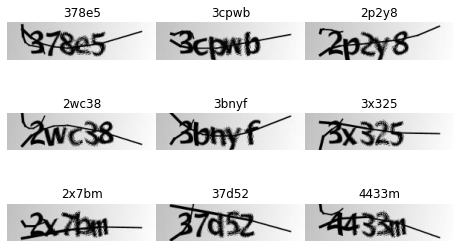

In [199]:
data_path = 'samples'
images = os.listdir(data_path)
sample_images = images[-9:]
fig, ax = plt.subplots(3, 3, figsize=(8, 5))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(9):
  img = cv2.imread(str(data_path + '/' + sample_images[i]))
  ax[i//3, i%3].imshow(img)
  ax[i//3, i%3].axis('off')
  ax[i//3, i%3].set_title(sample_images[i].split('.')[0])

# Image Preprocessing

In this section we are going preprocess a sample with opencv, remove the background noise line, let's take a look at the steps:

[**Simple Thresholding**](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)

* If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value.

**Median Blur**

* 


In [206]:
cv2.medianBlur?

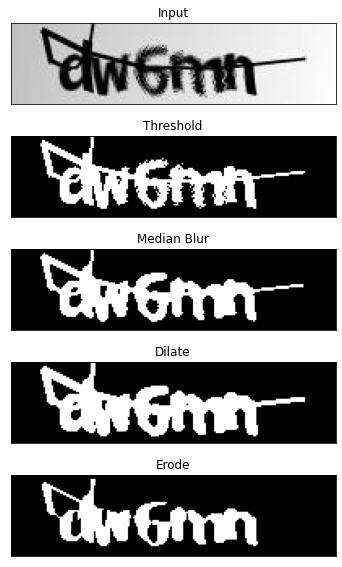

In [235]:
image_number = 138
image = cv2.imread(data_path + '/' + images[image_number], cv2.IMREAD_GRAYSCALE)

ret, threshold = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

blur = cv2.medianBlur(threshold, 3)

kernel = np.ones([2, 2], np.uint8)
dilate = cv2.dilate(blur, kernel, iterations=1)

kernel = np.ones([5, 1], np.uint8)
erode = cv2.erode(dilate, kernel, iterations=1)

plot = [image, threshold, blur, dilate, erode]
title = ['Input', 'Threshold', 'Median Blur', 'Dilate', 'Erode']

fig, ax = plt.subplots(5, 1, figsize=(15, 8))
fig.tight_layout()

for i, j, k in zip(range(len(plot)), plot, title):
  ax[i].imshow(j, cmap='gray')
  ax[i].set_title(k)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

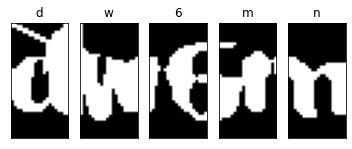

In [225]:
split = [erode[10:50,30:50],erode[10:50,50:70],
                 erode[10:50,70:90],erode[10:50,90:110],erode[10:50,110:130]]

label = images[image_number].split('.')[0]

fig, ax = plt.subplots(1, 5)
for i, j in zip(range(len(label)), label):
  ax[i].imshow(split[i])
  ax[i].set_title(j)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

Preprocess all images

In [ ]:
for i in images:
  print('Preprocessing: ' + i)

  image = cv2.imread(data_path + '/' + i, cv2.IMREAD_GRAYSCALE)

  ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
  image = cv2.medianBlur(image, 3)

  kernel = np.ones([2, 2], np.uint8)
  image = cv2.dilate(image, kernel, iterations=1)

  kernel = np.ones([5, 1], np.uint8)
  image = cv2.erode(image, kernel, iterations=1)

  split=[image[10:50,30:50],image[10:50,50:70],
         image[10:50,70:90],image[10:50,90:110],
         image[10:50,110:130]]
  
 # for i in range(len(split)):


In [239]:
#keras.preprocessing.image.img_to_array(split[0])

array([[[255., 255., 255.],
        [255., 255., 255.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [  0.,   0.,   0.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,  